# Suicide Rate Prediction Regression Model

The purpose of this notebook is to create a regression model to predict the suicide rate of a city in a certain year. 

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located and the suicide rate from the previous year.

---

Import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# DataPrep
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import pickle
import joblib

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import geoplot
# import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../"

In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [ ]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("/")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [ ]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

Filling NaN values with zero and getting state code from MUNCOD column

In [ ]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
df = df[(np.abs(stats.zscore(df["RATE"])) < 3)] 
df.head()

In [ ]:
df.to_csv("df_regression.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [ ]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

In [ ]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
train_df = train_df[(np.abs(stats.zscore(train_df["RATE"])) < 3)] 

train_df.head()

In [ ]:
train_df.to_csv("train_data_regression.csv")

Getting testing data (2018)

In [ ]:
percentage_valid_values = 0.8
col_year_suicide = "RATE_18"
col_year_prev = "RATE_17"
test_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
test_df = test_df.rename(columns={col_year_suicide: "RATE"})
test_df = test_df.rename(columns={col_year_prev: "PREVIOUS"})
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df = disease_df.rename(columns={col_year_disease: disease})

    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)  
test_df = test_df.dropna(thresh=N)

test_df.head()

In [ ]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)

# Removing outliers
test_df = test_df[(np.abs(stats.zscore(test_df["RATE"])) < 3)] 

In [ ]:
test_df.to_csv("test_data_regression.csv")

In [ ]:
test_df = pd.read_csv("test_data_regression.csv", index_col=0)

# Model

In [3]:
df = pd.read_csv("df_regression.csv",index_col=0)
train_df = pd.read_csv("train_data_regression.csv", index_col=0)
test_df = pd.read_csv("test_data_regression.csv", index_col=0)

In [4]:
num_feat = 50
corr_min_value = 0.05
all_models_scores = {}

In [5]:
def cor_feature_selector(X,y,corr_min_value):
    cor_list = []
    for i in list(X.columns):
        cor = np.corrcoef(X[i], y)[0,1]
        cor_list.append([i, cor])
    cor_feature = [x[0] for x in cor_list if abs(x[1]) > corr_min_value]
    print(len(cor_feature), "selected features (correlation)")
    return cor_feature

In [6]:
X_train_2018 = train_df.drop(columns=["RATE"])
y_train_2018 = train_df["RATE"]

selected_cor_features = cor_feature_selector(X_train_2018, y_train_2018, corr_min_value)

with open('selected_cor_features', 'wb') as fp:
    pickle.dump(selected_cor_features, fp)

X_train_2018 = X_train_2018[selected_cor_features]

mm_x_2018 = MinMaxScaler()
mm_y_2018 = MinMaxScaler()
mm_x_2018.fit(X_train_2018)
y_train_2018_reshape = y_train_2018.values.reshape(-1, 1)
mm_y_2018.fit(y_train_2018_reshape)

joblib.dump(mm_x_2018, root + "Dashboard/Models/sav/mm_x_regression.save")
joblib.dump(mm_y_2018, root + "Dashboard/Models/sav/mm_y_regression.save")

126 selected features (correlation)


['../../Dashboard/Models/sav/mm_y_regression.save']

Defining X and y

In [7]:
X = df.drop(columns=["RATE"])
y = df["RATE"]

X.shape

(9640, 341)

Defining some functions

In [8]:
def calcUpMetrics(y_pred,y_test,X_test, score, prefix):
    up_df = pd.DataFrame({"Pred": y_pred, "Real": y_test, "Previous": X_test["PREVIOUS"]})
    up_df["UP"] = up_df["Previous"] < up_df["Real"]
    up_df["UP_PRED"] = up_df["Previous"] < up_df["Pred"]
    up_df["UP"] = up_df["UP"].astype(int)
    up_df["UP_PRED"] = up_df["UP_PRED"].astype(int)
    score[prefix + '_acc'] = metrics.accuracy_score(up_df["UP"], up_df["UP_PRED"])
    score[prefix + '_recall_score'] = metrics.recall_score(up_df["UP"], up_df["UP_PRED"])
    score[prefix + '_precision_score'] = metrics.precision_score(up_df["UP"], up_df["UP_PRED"])
    score[prefix + '_f1_score'] = metrics.f1_score(up_df["UP"], up_df["UP_PRED"])

In [9]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores):
    rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,y_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
    rmse_baseline_train = np.sqrt(metrics.mean_squared_error(X_train["PREVIOUS"],y_train))
    rmse_baseline_test = np.sqrt(metrics.mean_squared_error(X_test["PREVIOUS"],y_test))

    score = {'rmse_train':rmse_train, 
             'rmse_test':rmse_test, 
             'rmse_baseline_train': rmse_baseline_train, 
             "rmse_baseline_test": rmse_baseline_test}    

    up_down_train = calcUpMetrics(y_pred_train, y_train,X_train, score, 'up_down_train')
    up_down_test = calcUpMetrics(y_pred,y_test, X_test, score, 'up_down_test')

    display(score)

    scores = scores.append(score, ignore_index=True)
    return scores

In [10]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature")
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df

## LinearRegression

In [11]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame()
count = 1

feature_importance_coef_list = []
feature_importance_shap_list = []

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    mm_x.fit(X_train)

    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    mm_y.fit(y_reshape)
    
    X_train_transf = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_transf = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train_transf = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Fitting the model")
    regressor = LinearRegression()
    regressor.fit(X_train_transf, y_train_transf.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test_transf) 
    y_pred_train = regressor.predict(X_train_transf)
    y_pred_train_reshaped = mm_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = mm_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = mm_y.inverse_transform(y_train_transf.values)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("# Get Feature Importance")
    feature_importance_coef_list.append(pd.DataFrame({"Feature": X_train_transf.columns, "Importance": regressor.coef_}).sort_values(by="Importance", ascending=False))

    explainer = shap.LinearExplainer(regressor, X_train_transf)
    shap_values = explainer.shap_values(X_test_transf)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X_test_transf.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
                                        
    print("\n")
    count += 1
print("=============== SUMMARY LinearRegression ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["LinearRegression"] = scores
                                   
print("# Average Feature Importance")
final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_linear_regression.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_linear_regression.csv")
                                   
end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_LinearRegression.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.5556264782723215,
 'rmse_test': 3.7028201907691285,
 'rmse_baseline_train': 4.968428887729926,
 'rmse_baseline_test': 4.852756179751097,
 'up_down_train_acc': 0.6886670124481328,
 'up_down_train_recall_score': 0.7895042041171354,
 'up_down_train_precision_score': 0.6191450659390633,
 'up_down_train_f1_score': 0.6940231935771632,
 'up_down_test_acc': 0.6696058091286307,
 'up_down_test_recall_score': 0.7702380952380953,
 'up_down_test_precision_score': 0.5930339138405133,
 'up_down_test_f1_score': 0.6701191092698084}

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


{'rmse_train': 3.5871278461993863,
 'rmse_test': 3.568938135953533,
 'rmse_baseline_train': 4.9829751515185725,
 'rmse_baseline_test': 4.792725690796757,
 'up_down_train_acc': 0.6824429460580913,
 'up_down_train_recall_score': 0.7776798825256975,
 'up_down_train_precision_score': 0.6101382488479262,
 'up_down_train_f1_score': 0.6837959974176888,
 'up_down_test_acc': 0.6945020746887967,
 'up_down_test_recall_score': 0.7997737556561086,
 'up_down_test_precision_score': 0.6318141197497766,
 'up_down_test_f1_score': 0.7059410883674488}

# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


127 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.559240811049853,
 'rmse_test': 3.6596371670538894,
 'rmse_baseline_train': 4.926016728480818,
 'rmse_baseline_test': 5.022730507675877,
 'up_down_train_acc': 0.6858143153526971,
 'up_down_train_recall_score': 0.7796312554872695,
 'up_down_train_precision_score': 0.6146746654360867,
 'up_down_train_f1_score': 0.6873951748161528,
 'up_down_test_acc': 0.6903526970954357,
 'up_down_test_recall_score': 0.7729357798165137,
 'up_down_test_precision_score': 0.6281453867660765,
 'up_down_test_f1_score': 0.6930591259640103}

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


{'rmse_train': 3.54138852651426,
 'rmse_test': 3.7211292963254987,
 'rmse_baseline_train': 4.930784973910473,
 'rmse_baseline_test': 5.003980730784661,
 'up_down_train_acc': 0.6893153526970954,
 'up_down_train_recall_score': 0.7875,
 'up_down_train_precision_score': 0.6193415637860082,
 'up_down_train_f1_score': 0.6933708727924239,
 'up_down_test_acc': 0.6768672199170125,
 'up_down_test_recall_score': 0.7750294464075382,
 'up_down_test_precision_score': 0.6036697247706422,
 'up_down_test_f1_score': 0.6787003610108303}

# Get Feature Importance


=============== RUN 5 ===============


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Feature Selection: correlation
125 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.574069170427605,
 'rmse_test': 3.5903681667897707,
 'rmse_baseline_train': 4.919021930072528,
 'rmse_baseline_test': 5.050077028688922,
 'up_down_train_acc': 0.685554979253112,
 'up_down_train_recall_score': 0.7886792452830189,
 'up_down_train_precision_score': 0.6155414589941096,
 'up_down_train_f1_score': 0.6914365695381091,
 'up_down_test_acc': 0.678941908713693,
 'up_down_test_recall_score': 0.7760663507109005,
 'up_down_test_precision_score': 0.6036866359447005,
 'up_down_test_f1_score': 0.6791083462934162}

# Get Feature Importance


=============== SUMMARY LinearRegression ===============
# Average Metrics
rmse_baseline_test               4.944454
rmse_baseline_train              4.945446
rmse_test                        3.648579
rmse_train                       3.563491
up_down_test_acc                 0.682054
up_down_test_f1_score            0.685386
up_down_test_precision_score     0.612070
up_down_test_recall_score        0.778809
up_down_train_acc                0.686359
up_down_train_f1_score           0.690004
up_down_train_precision_score    0.615768
up_down_train_recall_score       0.784599
dtype: float64
# Average Feature Importance


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)



Total run time: 1.237544059753418

=============== SAVE Y_TEST_PRED ===============


In [12]:
explainer = shap.LinearExplainer(regressor, X_train_transf)
shap_values = explainer.shap_values(X_test_transf)
vals= np.abs(shap_values).mean(0)
feature_importance_shap = pd.DataFrame(list(zip(X_test_transf.columns,vals)),columns=['Feature','Importance'])
feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
feature_importance_shap_list.append(feature_importance_shap)


# SHAP analysis


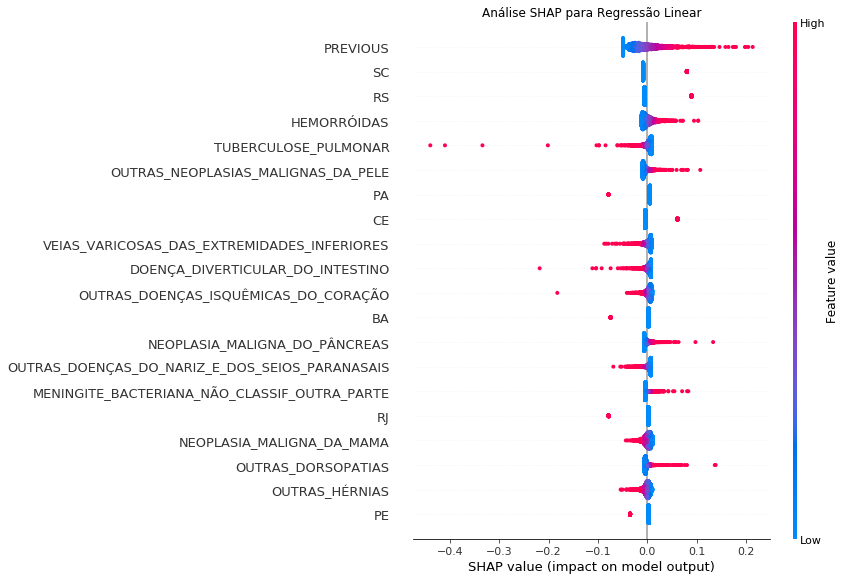

In [13]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(regressor, X_train_transf)
shap_values = explainer.shap_values(X_test_transf)
shap.summary_plot(shap_values, X_test_transf, feature_names=X_test_transf.columns, show=False)
plt.title("Análise SHAP para Regressão Linear")
plt.savefig("linear_regression_shap.png", bbox_inches = "tight")

In [14]:
y_df = y_train_2018.to_frame()

X_train = pd.DataFrame(mm_x_2018.transform(X_train_2018), index=X_train_2018.index, columns=X_train_2018.columns)
y_train = pd.DataFrame(mm_y_2018.transform(y_train_2018_reshape), index=y_df.index, columns=y_df.columns)

regressor = LinearRegression()
regressor.fit(X_train, y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/linear_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## ElasticNet

In [15]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame()
count = 1

feature_importance_coef_list = []
feature_importance_shap_list = []

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    mm_x.fit(X_train)

    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    mm_y.fit(y_reshape)

    X_train_transf = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_transf = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train_transf = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        alpha = params[0]
        l1_ratio = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = ElasticNet(random_state=42, alpha=alpha, l1_ratio=l1_ratio, tol=0.5)

        model.fit(xf_train_params, yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.01,100), #alpha
        (0,1),      #l1_ratio
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=15, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = ElasticNet(random_state=42, alpha=resultado_gp.x[0], l1_ratio=resultado_gp.x[1], tol=0.5)
    regressor.fit(X_train_transf, y_train_transf.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test_transf) 
    y_pred_train = regressor.predict(X_train_transf)
    y_pred_train_reshaped = mm_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = mm_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = mm_y.inverse_transform(y_train_transf.values)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("# Get Feature Importance")
    feature_importance_coef_list.append(pd.DataFrame({"Feature": X_train_transf.columns, "Importance": regressor.coef_}).sort_values(by="Importance", ascending=False))

    explainer = shap.LinearExplainer(regressor, X_train_transf)
    shap_values = explainer.shap_values(X_test_transf)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X_test_transf.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
                                        
    print("\n")
    count += 1
print("=============== SUMMARY LinearRegression ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["ElasticNet"] = scores
                                   
print("# Average Feature Importance")
final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_elastic_net.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_elastic_net.csv")
                                   
end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_ElasticNet.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.620975811939771,
 'rmse_test': 3.667592585712186,
 'rmse_baseline_train': 4.968428887729926,
 'rmse_baseline_test': 4.852756179751097,
 'up_down_train_acc': 0.6816649377593361,
 'up_down_train_recall_score': 0.7915337779066396,
 'up_down_train_precision_score': 0.6112852664576802,
 'up_down_train_f1_score': 0.689829437776374,
 'up_down_test_acc': 0.6623443983402489,
 'up_down_test_recall_score': 0.775,
 'up_down_test_precision_score': 0.5849056603773585,
 'up_down_test_f1_score': 0.6666666666666666}

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.654889032880439,
 'rmse_test': 3.5793773913273643,
 'rmse_baseline_train': 4.9829751515185725,
 'rmse_baseline_test': 4.792725690796757,
 'up_down_train_acc': 0.67673755186722,
 'up_down_train_recall_score': 0.7861967694566814,
 'up_down_train_precision_score': 0.6026564610535795,
 'up_down_train_f1_score': 0.6822989677583791,
 'up_down_test_acc': 0.6820539419087137,
 'up_down_test_recall_score': 0.7986425339366516,
 'up_down_test_precision_score': 0.6187554776511832,
 'up_down_test_f1_score': 0.697283950617284}

# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.6178607920123556,
 'rmse_test': 3.6775218837493333,
 'rmse_baseline_train': 4.926016728480818,
 'rmse_baseline_test': 5.022730507675877,
 'up_down_train_acc': 0.6773858921161826,
 'up_down_train_recall_score': 0.7837284167398303,
 'up_down_train_precision_score': 0.6049243279873503,
 'up_down_train_f1_score': 0.6828148903620601,
 'up_down_test_acc': 0.6867219917012448,
 'up_down_test_recall_score': 0.7935779816513762,
 'up_down_test_precision_score': 0.6200716845878136,
 'up_down_test_f1_score': 0.6961770623742455}

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.606603714740167,
 'rmse_test': 3.7290059457230416,
 'rmse_baseline_train': 4.930784973910473,
 'rmse_baseline_test': 5.003980730784661,
 'up_down_train_acc': 0.6795902489626556,
 'up_down_train_recall_score': 0.7909883720930233,
 'up_down_train_precision_score': 0.608316566063045,
 'up_down_train_f1_score': 0.6877290534563377,
 'up_down_test_acc': 0.6742738589211619,
 'up_down_test_recall_score': 0.7868080094228505,
 'up_down_test_precision_score': 0.5991031390134529,
 'up_down_test_f1_score': 0.6802443991853361}

# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.6388695420209753,
 'rmse_test': 3.6033942836879422,
 'rmse_baseline_train': 4.919021930072528,
 'rmse_baseline_test': 5.050077028688922,
 'up_down_train_acc': 0.6782935684647303,
 'up_down_train_recall_score': 0.7959361393323657,
 'up_down_train_precision_score': 0.606637168141593,
 'up_down_train_f1_score': 0.688512241054614,
 'up_down_test_acc': 0.678941908713693,
 'up_down_test_recall_score': 0.7879146919431279,
 'up_down_test_precision_score': 0.6018099547511312,
 'up_down_test_f1_score': 0.6824012314007182}

# Get Feature Importance


=============== SUMMARY LinearRegression ===============
# Average Metrics
rmse_baseline_test               4.944454
rmse_baseline_train              4.945446
rmse_test                        3.651378
rmse_train                       3.627840
up_down_test_acc                 0.676867
up_down_test_f1_score            0.684555
up_down_test_precision_score     0.604929
up_down_test_recall_score        0.788389
up_down_train_acc                0.678734
up_down_train_f1_score           0.686237
up_down_train_precision_score    0.606764
up_down_train_recall_score       0.789677
dtype: float64
# Average Feature Importance

Total run time: 8.63489294052124

=============== SAVE Y_TEST_PRED ===============


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# SHAP analysis


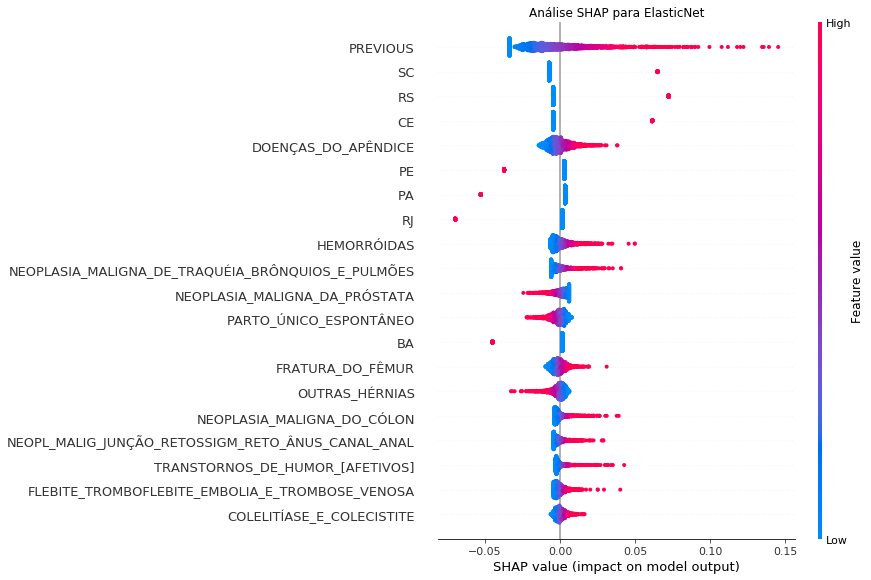

In [16]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(regressor, X_train_transf)
shap_values = explainer.shap_values(X_test_transf)
shap.summary_plot(shap_values, X_test_transf, feature_names=X_test_transf.columns, show=False)
plt.title("Análise SHAP para ElasticNet")
plt.savefig("elasticnet_regression_shap.png", bbox_inches = "tight")

In [17]:
y_df = y_train_2018.to_frame()

X_train = pd.DataFrame(mm_x_2018.transform(X_train_2018), index=X_train_2018.index, columns=X_train_2018.columns)
y_train = pd.DataFrame(mm_y_2018.transform(y_train_2018_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    alpha = params[0]
    l1_ratio = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = ElasticNet(random_state=42, alpha=alpha, l1_ratio=l1_ratio, tol=0.5)

    model.fit(xf_train_params, yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.01,100), #alpha
    (0,1),      #l1_ratio
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=15, n_random_starts=10)

regressor = ElasticNet(random_state=42, alpha=resultado_gp.x[0], l1_ratio=resultado_gp.x[1], tol=0.5)
regressor.fit(X_train, y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/elastic_net_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## Random Forest

In [22]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame()
feature_importance_list = []
feature_importance_shap_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (5,1000),   #n_estimators
        (3,30),     #max_depth
        (2,200),    #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                                  max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_test)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)    
    
    print("\n")
    count += 1
print("=============== SUMMARY Random Forest ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["Random Forest"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
final_feat_df.to_csv("fi_random_forest_regression.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_random_forest.csv")
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 1.5453095976914502,
 'rmse_test': 3.646251590029542,
 'rmse_baseline_train': 4.968428887729926,
 'rmse_baseline_test': 4.852756179751097,
 'up_down_train_acc': 0.8582728215767634,
 'up_down_train_recall_score': 0.9588286459843433,
 'up_down_train_precision_score': 0.77665570690465,
 'up_down_train_f1_score': 0.8581808745296484,
 'up_down_test_acc': 0.6535269709543569,
 'up_down_test_recall_score': 0.7821428571428571,
 'up_down_test_precision_score': 0.5753064798598949,
 'up_down_test_f1_score': 0.6629667003027245}

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 1.677651165800043,
 'rmse_test': 3.5317366757855844,
 'rmse_baseline_train': 4.9829751515185725,
 'rmse_baseline_test': 4.792725690796757,
 'up_down_train_acc': 0.8489367219917012,
 'up_down_train_recall_score': 0.9491923641703377,
 'up_down_train_precision_score': 0.7651515151515151,
 'up_down_train_f1_score': 0.8472932232271595,
 'up_down_test_acc': 0.6804979253112033,
 'up_down_test_recall_score': 0.8076923076923077,
 'up_down_test_precision_score': 0.6155172413793103,
 'up_down_test_f1_score': 0.6986301369863014}

# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 1.6069895592273595,
 'rmse_test': 3.633838250064055,
 'rmse_baseline_train': 4.926016728480818,
 'rmse_baseline_test': 5.022730507675877,
 'up_down_train_acc': 0.8517894190871369,
 'up_down_train_recall_score': 0.9520046824700029,
 'up_down_train_precision_score': 0.7686672967863895,
 'up_down_train_f1_score': 0.8505687017910839,
 'up_down_test_acc': 0.6841286307053942,
 'up_down_test_recall_score': 0.8119266055045872,
 'up_down_test_precision_score': 0.614050303555941,
 'up_down_test_f1_score': 0.6992592592592594}

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 1.6505783259567823,
 'rmse_test': 3.684400787756878,
 'rmse_baseline_train': 4.930784973910473,
 'rmse_baseline_test': 5.003980730784661,
 'up_down_train_acc': 0.847899377593361,
 'up_down_train_recall_score': 0.9468023255813953,
 'up_down_train_precision_score': 0.7668942783141041,
 'up_down_train_f1_score': 0.8474047092493819,
 'up_down_test_acc': 0.6737551867219918,
 'up_down_test_recall_score': 0.7950530035335689,
 'up_down_test_precision_score': 0.5973451327433629,
 'up_down_test_f1_score': 0.6821627084386054}

# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 1.4753249583843797,
 'rmse_test': 3.5614896508687734,
 'rmse_baseline_train': 4.919021930072528,
 'rmse_baseline_test': 5.050077028688922,
 'up_down_train_acc': 0.8690352697095436,
 'up_down_train_recall_score': 0.9718432510885341,
 'up_down_train_precision_score': 0.7857310490495188,
 'up_down_train_f1_score': 0.8689332987282636,
 'up_down_test_acc': 0.6779045643153527,
 'up_down_test_recall_score': 0.8092417061611374,
 'up_down_test_precision_score': 0.5975503062117236,
 'up_down_test_f1_score': 0.6874685455460493}

# Get Feature Importance


=============== SUMMARY Random Forest ===============
# Average Metrics
rmse_baseline_test               4.944454
rmse_baseline_train              4.945446
rmse_test                        3.611543
rmse_train                       1.591171
up_down_test_acc                 0.673963
up_down_test_f1_score            0.686097
up_down_test_precision_score     0.599954
up_down_test_recall_score        0.801211
up_down_train_acc                0.855187
up_down_train_f1_score           0.854476
up_down_train_precision_score    0.772620
up_down_train_recall_score       0.955734
dtype: float64
# Average Feature Importance
                                              Feature  Avg_importance
0                                            PREVIOUS        0.106051
1                                                  RS        0.027152
2       TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS        0.021893
3   TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT        0.013491
4  

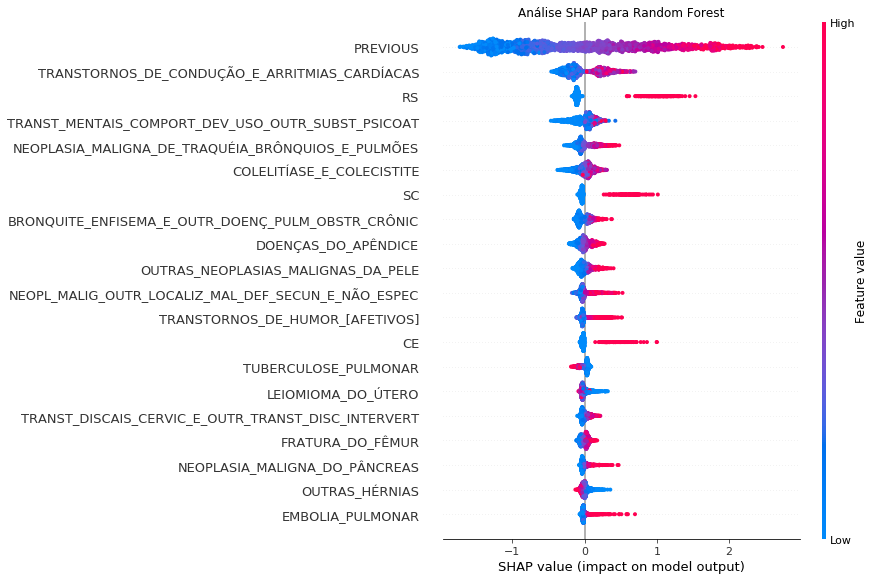

In [26]:
explainer = shap.TreeExplainer(regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.title("Análise SHAP para Random Forest")
plt.savefig("random_forest_regression_shap.png", bbox_inches = "tight")

In [24]:
X_train = X_train_2018
y_train = y_train_2018

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (5,1000),   #n_estimators
    (3,30),     #max_depth
    (2,200),    #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                              max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train, y_train)

filename = root + 'Dashboard/Models/sav/random_forest_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## SVR

In [18]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame()
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    mm_x.fit(X_train)
    
    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    mm_y.fit(y_reshape)
    
    X_train_transf = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_transf = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train_transf = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        gamma = params[0]
        C = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train_transf,y_train_transf.values.ravel(),test_size=0.33,random_state=42)

        model = SVR(gamma=gamma, C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.001,0.9), #gamma
        (1,10000),   #C
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
    regressor.fit(X_train_transf, y_train_transf.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test_transf) 
    y_pred_train = regressor.predict(X_train_transf)
    y_pred_train_reshaped = mm_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = mm_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = mm_y.inverse_transform(y_train_transf.values)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY SVR MM ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["SVR MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred_reshaped.ravel()})
y_test_pred.to_csv('y_test_pred_MinMax.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.3925962399751763,
 'rmse_test': 3.6549475451633713,
 'rmse_baseline_train': 4.968428887729926,
 'rmse_baseline_test': 4.852756179751097,
 'up_down_train_acc': 0.7066908713692946,
 'up_down_train_recall_score': 0.7808060307335459,
 'up_down_train_precision_score': 0.6413431769468921,
 'up_down_train_f1_score': 0.7042364016736402,
 'up_down_test_acc': 0.6732365145228216,
 'up_down_test_recall_score': 0.75,
 'up_down_test_precision_score': 0.6,
 'up_down_test_f1_score': 0.6666666666666665}



=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.4901307696281916,
 'rmse_test': 3.5390136777657735,
 'rmse_baseline_train': 4.9829751515185725,
 'rmse_baseline_test': 4.792725690796757,
 'up_down_train_acc': 0.6945020746887967,
 'up_down_train_recall_score': 0.7682819383259912,
 'up_down_train_precision_score': 0.6253884771694955,
 'up_down_train_f1_score': 0.6895097522403796,
 'up_down_test_acc': 0.6976141078838174,
 'up_down_test_recall_score': 0.7669683257918553,
 'up_down_test_precision_score': 0.6426540284360189,
 'up_down_test_f1_score': 0.6993295513151109}



=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.1330602241407126,
 'rmse_test': 3.6774728964896592,
 'rmse_baseline_train': 4.926016728480818,
 'rmse_baseline_test': 5.022730507675877,
 'up_down_train_acc': 0.7210840248962656,
 'up_down_train_recall_score': 0.8018729880011706,
 'up_down_train_precision_score': 0.6502135738016137,
 'up_down_train_f1_score': 0.7181234438474644,
 'up_down_test_acc': 0.6965767634854771,
 'up_down_test_recall_score': 0.7637614678899083,
 'up_down_test_precision_score': 0.6373205741626794,
 'up_down_test_f1_score': 0.6948356807511736}



=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.3783266073481917,
 'rmse_test': 3.7005901677599815,
 'rmse_baseline_train': 4.930784973910473,
 'rmse_baseline_test': 5.003980730784661,
 'up_down_train_acc': 0.7077282157676349,
 'up_down_train_recall_score': 0.7813953488372093,
 'up_down_train_precision_score': 0.641527446300716,
 'up_down_train_f1_score': 0.7045871559633028,
 'up_down_test_acc': 0.6836099585062241,
 'up_down_test_recall_score': 0.7479387514723204,
 'up_down_test_precision_score': 0.6159068865179438,
 'up_down_test_f1_score': 0.6755319148936171}



=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics


{'rmse_train': 3.4657375977237717,
 'rmse_test': 3.550850537784041,
 'rmse_baseline_train': 4.919021930072528,
 'rmse_baseline_test': 5.050077028688922,
 'up_down_train_acc': 0.7020228215767634,
 'up_down_train_recall_score': 0.7759071117561683,
 'up_down_train_precision_score': 0.6365801381281257,
 'up_down_train_f1_score': 0.6993720565149135,
 'up_down_test_acc': 0.6898340248962656,
 'up_down_test_recall_score': 0.764218009478673,
 'up_down_test_precision_score': 0.617816091954023,
 'up_down_test_f1_score': 0.6832627118644068}



=============== SUMMARY SVR MM ===============
# Average Metrics
rmse_baseline_test               4.944454
rmse_baseline_train              4.945446
rmse_test                        3.624575
rmse_train                       3.371970
up_down_test_acc                 0.688174
up_down_test_f1_score            0.683925
up_down_test_precision_score     0.622740
up_down_test_recall_score        0.758577
up_down_train_acc                0.706406
up_down_train_f1_score           0.703166
up_down_train_precision_score    0.639011
up_down_train_recall_score       0.781653
dtype: float64

Total run time: 1458.2140181064606

=============== SAVE Y_TEST_PRED ===============


In [21]:
y_df = y_train_2018.to_frame()

X_train = pd.DataFrame(mm_x_2018.transform(X_train_2018), index=X_train_2018.index, columns=X_train_2018.columns)
y_train = pd.DataFrame(mm_y_2018.transform(y_train_2018_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    gamma = params[0]
    C = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

    model = SVR(gamma=gamma, C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.001,0.9), #gamma
    (1,10000),   #C
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
regressor.fit(X_train,y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/svr_mm_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

# All Models

Getting a summary of all model results

In [25]:
df_result = pd.DataFrame()

for model,scores in all_models_scores.items():
    df_model = scores.mean().to_frame().transpose()
    df_model.insert(0, 'Model', model)
    df_result = df_result.append(df_model, ignore_index=True)

display(df_result)

,Model,rmse_baseline_test,rmse_baseline_train,rmse_test,rmse_train,up_down_test_acc,up_down_test_f1_score,up_down_test_precision_score,up_down_test_recall_score,up_down_train_acc,up_down_train_f1_score,up_down_train_precision_score,up_down_train_recall_score
0,LinearRegression,4.944454,4.945446,3.648579,3.563491,0.682054,0.685386,0.612070,0.778809,0.686359,0.690004,0.615768,0.784599
1,ElasticNet,4.944454,4.945446,3.651378,3.627840,0.676867,0.684555,0.604929,0.788389,0.678734,0.686237,0.606764,0.789677
2,SVR MM,4.944454,4.945446,3.624575,3.371970,0.688174,0.683925,0.622740,0.758577,0.706406,0.703166,0.639011,0.781653
3,Random Forest,4.944454,4.945446,3.611543,1.591171,0.673963,0.686097,0.599954,0.801211,0.855187,0.854476,0.772620,0.955734


<!-- ## AdaBoost -->

In [ ]:
# start = time.time()
# kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
# scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
# feature_importance_list = []
# count = 1
# for train_index, test_index in kf.split(X):
#     print("=============== RUN {} ===============".format(count))
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     print("# Feature Selection: correlation")
#     selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
#     X_train = X_train[selected_cor_features]
#     X_test = X_test[selected_cor_features]
    
#     print("# Bayesian Optimization")
#     def train_model(params):
#         n_estimators = params[0]
#         learning_rate = params[1]

#         xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

#         model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

#         model.fit(xf_train_params,yf_train_params)
#         yf_pred = model.predict(xf_val)

#         return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
#     space = [
#         (30,200), #n_estimators
#         (0.01, 1) #learning_rate
#     ]
#     resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
#     print("# Fitting the model")
#     regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
#     regressor.fit(X_train,y_train)
    
#     print("# Making predictions")
#     y_pred = regressor.predict(X_test) 
#     y_pred_train = regressor.predict(X_train)
    
#     print("# Calculating metrics")
#     scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
#     print("# Get Feature Importance")
#     importance = regressor.feature_importances_
#     feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
#     print("\n")
#     count += 1
# print("=============== SUMMARY AdaBoost ===============")
# print("# Average Metrics")
# print(scores.mean())
# all_models_scores["AdaBoost"] = scores
# print("# Average Feature Importance")
# final_feat_df = get_average_feat_importance(feature_importance_list)
# print(final_feat_df.head(20))
# end = time.time()

# print("\nTotal run time:", end-start)

# print("\n=============== SAVE Y_TEST_PRED ===============")
# y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
# y_test_pred.to_csv('y_test_pred_AdaBoost.csv')

In [ ]:
# X_train = train_df.drop(columns=["RATE"])
# y_train = train_df["RATE"]

# with open('selected_cor_features', 'rb') as f:
#     selected_cor_features = pickle.load(f)
    
# X_train = X_train[selected_cor_features]

# def train_model(params):
#     n_estimators = params[0]
#     learning_rate = params[1]

#     xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

#     model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

#     model.fit(xf_train_params,yf_train_params)
#     yf_pred = model.predict(xf_val)

#     return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
# space = [
#     (30,200), #n_estimators
#     (0.01, 1) #learning_rate
# ]
# resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

# regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
# regressor.fit(X_train,y_train)

# filename = root + 'Dashboard/Models/sav/adaboost_regression.sav'
# pickle.dump(regressor, open(filename, 'wb'))

<!-- ## Gradient Boosting -->

In [ ]:
# from sklearn.model_selection import KFold
# start = time.time()
# kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
# scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
# feature_importance_list = []
# count = 1
# for train_index, test_index in kf.split(X):
#     print("=============== RUN {} ===============".format(count))
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     print("# Feature Selection: correlation")
#     selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
#     X_train = X_train[selected_cor_features]
#     X_test = X_test[selected_cor_features]
    
#     print("# Bayesian Optimization")
#     def train_model(params):
#         n_estimators = params[0]
#         learning_rate = params[1]
#         max_depth = params[2]
#         min_samples_splits = params[3]
#         min_samples_leafs = params[4]

#         xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

#         model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
#                                           max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

#         model.fit(xf_train_params,yf_train_params)
#         yf_pred = model.predict(xf_val)

#         return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
#     space = [
#         (30,200),  #n_estimators
#         (0.01, 1), #learning_rate
#         (1,32),    #max_depth
#         (0.1, 1),  #min_samples_splits 
#         (0.1, 0.5) #min_samples_leafs 
#     ]
#     resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
#     print("# Fitting the model")
#     regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
#                                          max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
#     regressor.fit(X_train,y_train)
    
#     print("# Making predictions")
#     y_pred = regressor.predict(X_test) 
#     y_pred_train = regressor.predict(X_train)
    
#     print("# Calculating metrics")
#     scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
#     print("# Get Feature Importance")
#     importance = regressor.feature_importances_
#     feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
#     print("\n")
#     count += 1
# print("=============== SUMMARY Gradient Boosting ===============")
# print("# Average Metrics")
# print(scores.mean())
# all_models_scores["Gradient Boosting"] = scores
# print("# Average Feature Importance")
# final_feat_df = get_average_feat_importance(feature_importance_list)
# print(final_feat_df.head(20))
# end = time.time()

# print("\nTotal run time:", end-start)

# print("\n=============== SAVE Y_TEST_PRED ===============")
# y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
# y_test_pred.to_csv('y_test_pred_GradientBoosting.csv')

In [ ]:
# X_train = train_df.drop(columns=["RATE"])
# y_train = train_df["RATE"]

# with open('selected_cor_features', 'rb') as f:
#     selected_cor_features = pickle.load(f)
    
# X_train = X_train[selected_cor_features]

# def train_model(params):
#     n_estimators = params[0]
#     learning_rate = params[1]
#     max_depth = params[2]
#     min_samples_splits = params[3]
#     min_samples_leafs = params[4]

#     xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

#     model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
#                                       max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

#     model.fit(xf_train_params,yf_train_params)
#     yf_pred = model.predict(xf_val)

#     return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
# space = [
#     (30,200), #n_estimators
#     (0.01, 1), #learning_rate
#     (1,32), #max_depth
#     (0.1, 1), #min_samples_splits 
#     (0.1, 0.5) #min_samples_leafs 
# ]
# resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

# regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
#                                      max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
# regressor.fit(X_train,y_train)

# filename = root + 'Dashboard/Models/sav/gradient_boost_regression.sav'
# pickle.dump(regressor, open(filename, 'wb'))